In [1]:
import os
import configparser
import logging
import numpy as np
import torch
import cv2
import pandas as pd
from PIL import Image
from meegnet_functions import load_single_subject
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from meegnet.parsing import parser, save_config
from meegnet.dataloaders import EpochedDataset
from meegnet.network import Model
from mne.viz import plot_topomap
from sklearn.decomposition import PCA

info = np.load(f"../camcan_info_mag.npy", allow_pickle=True).tolist()

In [2]:
# We set up our data to be 3 channel types (MAG GRAD GRAD),
# 102 sensor locations (Elekta Neuromag Vector View 306 channel MEG),
# and 400 time samples for 800ms of signal sampled as 500Hz.
n_channels = "ALL"
input_size = (3, 102, 400)

n_outputs = 2 # using auditory vs visual stimulus classification -> 2 classes
n_subjects = 100
n_samples = None # We will use all trials for each subject

# Setting up paths
classif = "eventclf" # also used for naming files and for model name
save_path = f"/home/arthur/data/camcan/{classif}"
model_path = save_path

In [3]:
import meegnet.network as mn
import importlib
importlib.reload(mn)

# setting up a seed for reproducibility (will be used for numpy, pandas, torch, and the meegnet library)
seed = 42 

# net option can be "meegnet", "eegnet" etc, see documentation
# net_option = "meegnet" 
net_option = "eegnet" 

# name of the model
name = f"{classif}_{net_option}_{seed}_{n_channels}"

my_model = mn.Model(name, net_option, input_size, n_outputs, save_path=save_path)
# my_model.from_pretrained()
model_path = os.path.join(save_path, name + ".pt")
my_model.load(model_path)
print("Model Loaded.")

fig_path = os.path.join(save_path, "figures", name)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

Model Loaded.


/home/arthur/.pyvenvs/camcan/lib/python3.12/site-packages/meegnet/network.py:958: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [4]:
csv_file = os.path.join(save_path, f"participants_info.csv")
dataframe = (
    pd.read_csv(csv_file, index_col=0)
    .sample(frac=1, random_state=seed)
    .reset_index(drop=True)[: n_subjects]
)
subj_list = dataframe["sub"]
np.random.seed(seed)

dataset = EpochedDataset(
        sfreq=500, # sampling frequency of 500Hz
        n_subjects=n_subjects,
        n_samples=n_samples,
        sensortype='ALL', # we use MAG GRAD GRAD here
        lso=True,
        random_state=seed,
)
dataset.load(save_path, one_sub=subj_list[12])

In [5]:
for i, layer in enumerate(my_model.net.feature_extraction):
    print(i, layer)

0 Conv2d(3, 16, kernel_size=(1, 64), stride=(1, 1), padding=(1, 32), bias=False)
1 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 DepthwiseConv2d(
  (depthwise): Conv2d(16, 32, kernel_size=(102, 1), stride=(1, 1), groups=16, bias=False)
)
3 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
4 ELU(alpha=1.0)
5 AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
6 Dropout(p=0.5, inplace=False)
7 SeparableConv2d(
  (depthwise): DepthwiseConv2d(
    (depthwise): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(1, 8), groups=32, bias=False)
  )
  (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 8), bias=False)
)
8 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
9 ELU(alpha=1.0)
10 AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
11 Dropout(p=0.5, inplace=False)
12 Flatten()


In [10]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam import GuidedBackpropReLUModel

labels = ['auditory', 'visual']
all_cams = []
for i, label in enumerate(labels):
    net = my_model.net
    
    layer = net.feature_extraction[2]
    target_layers = [layer]
    
    gradcam = GradCAM(model=net, target_layers=target_layers)
    input_tensor = dataset.data[dataset.labels == i][-20:]
        
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = gradcam(input_tensor=input_tensor,
                            targets=[ClassifierOutputTarget(i)])
                            # targets=None)
    
    all_cams.append(grayscale_cam)
    grayscale_cam = grayscale_cam[0, :]
    img = np.moveaxis(np.array(input_tensor[0]), 0, 2)
    img = np.array([img[:,:,0]]*3)
    img = np.moveaxis(img, 0, 2)
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
    
    # gb_model = GuidedBackpropReLUModel(model=net, device='cuda')
    # gb = gb_model(input_tensor)
    
    # cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    # cam_gb = deprocess_image(cam_mask * gb)
    # gb = deprocess_image(gb)
    
    method = "GradCAM"
    cam_output_path = os.path.join(fig_path, f'{name}_{method}_{label}_cam.png')
    # gb_output_path = f'{method}_gb.jpg'
    # cam_gb_output_path = f'{method}_cam_gb.jpg'
    
    if os.path.exists(cam_output_path):
        os.remove(cam_output_path)
    cv2.imwrite(cam_output_path, cam_image)
    # cv2.imwrite(gb_output_path, gb)
    # cv2.imwrite(cam_gb_output_path, cam_gb)
 

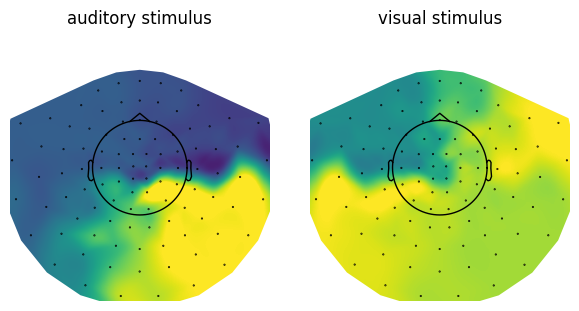

In [15]:
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=2, layout="constrained")
plt.title("PCA of Gradcam mask")

for i, label in enumerate(labels): 
    cams = all_cams[i]
    
    pca = PCA(1)
    # pca.fit(cams.mean(axis=0).T)
    pca.fit(cams[0].T)
    component = pca.components_[0]

    axes[i].set_title(f"{label} stimulus")
    im, _ = plot_topomap(
        component,
        # grayscale_cam[:,140],
        info,
        axes=axes[i],
        res=300,
        show=False,
        contours=0,
        cmap='viridis'
    )
    
out_path = os.path.join(fig_path, f"{method}_mask_PCA.png")
# plt.tight_layout()
plt.savefig(out_path, dpi=300)
plt.show()